# Convolutional Neural Network

### Author: Ivan Bongiorni, Data Scientist at GfK.

[LinkedIn profile](https://www.linkedin.com/in/ivan-bongiorni-b8a583164/)

In this Notebook I will implement a **basic CNN in TensorFlow 2.0**. I will use the famous **Fashion MNIST** dataset, [published by Zalando](https://github.com/zalandoresearch/fashion-mnist) and made [available on Kaggle](https://www.kaggle.com/zalando-research/fashionmnist). Images come already preprocessed in 28 x 28 black and white format.

It is a multiclass classification task on the following labels:
0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot 

![](https://limetta.se/globalassets/nyhetbloggpress-bilder/fashion-mnist.jpg)

Summary:

0. Import data + Dataprep
0. CNN architecture
0. Training with Mini Batch Gradient Descent
0. Test

In [2]:
# Import necessary modules

import numpy as np
import pandas as pd

import tensorflow as tf
print(tf.__version__)

from sklearn.utils import shuffle

from matplotlib import pyplot as plt
import seaborn

2.0.0-beta0


# 0. Import data + Dataprep

The dataset comes already divided in 60k and 10k Train and Test images. I will now import Training data, and leave Test for later. In order to dataprep image data, I need to reshape the pixel into `(, 28, 28, 1)` arrays; the 1 at the end represents the channel: 1 for black and white images, 3 (red, green, blue) for colored images. Pixel data are also scaled to the `[0, 1]` interval.

In [3]:
df = pd.read_csv('fashion-mnist_train.csv')

# extract labels, one-hot encode them
label = df.label
label = pd.get_dummies(label)
label = label.values
label = label.astype(np.float32)

df.drop('label', axis = 1, inplace = True)
df = df.values
df = df.astype(np.float32)

# reshape and scale data
df = df.reshape((len(df), 28, 28, 1))
df = df / 255.

# 1. CNN architecture

I will feed images into a set of **convolutional** and **max-pooling layers**:

- Conv layers are meant to extract relevant informations from pixel data. A number of *filters* scroll through the image, learning the most relevant informations to extract.
- Max-Pool layers instead are meant to drastically reduce the number of pixel data. For each (2, 2) window size, Max-Pool will save only the pixel with the highest activation value. Max-Pool is meant to make the model lighter by removing the least relevant observations, at the cost of course of loosing a lot of data!

Since I'm focused on the implementation, rather than on the theory behind it, please refer to [this good article](https://towardsdatascience.com/types-of-convolutions-in-deep-learning-717013397f4d) on how Conv and Max-Pool work in practice. If you are a die-hard, check [this awesome page from a CNN Stanford Course](http://cs231n.github.io/convolutional-networks/?source=post_page---------------------------#overview).

Con and Max-Pool will extract and reduce the size of the input, so that the following feed-forward part could process it. The first convolutional layer requires a specification of the input shape, corresponding to the shape of each image.

Since it's a multiclass classification tasks, softmax activation must be placed at the output layer in order to transform the Network's output into a probability distribution over the ten target categories.

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.activations import relu, elu, softmax


CNN = Sequential([
    
    Conv2D(32, kernel_size = (3, 3), activation = elu, 
           kernel_initializer = 'he_normal', input_shape = (28, 28, 1)), 
    MaxPool2D((2, 2)), 
    
    Conv2D(64, kernel_size = (3, 3), kernel_initializer = 'he_normal', activation = elu), 
    BatchNormalization(), 
    
    Conv2D(128, kernel_size = (3, 3), kernel_initializer = 'he_normal', activation = elu), 
    BatchNormalization(), 
    Dropout(0.2), 
    
    
    Flatten(), 
    
    
    Dense(400, activation = elu), 
    BatchNormalization(), 
    Dropout(0.2), 
    
    Dense(400, activation = elu), 
    BatchNormalization(), 
    Dropout(0.2), 
    
    Dense(10, activation = softmax)
    
])


In [1]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 128)         0

# 2. Training with Mini Batch Gradient Descent

The training part is no different from mini batch gradient descent training of feed-forward classifiers. I wrote [a Notebook on this technique](https://github.com/IvanBongiorni/TensorFlow2.0_Tutorial/blob/master/TensorFlow2.0_02_MiniBatch_Gradient_Descent.ipynb) in which I explain it in more detail.

Assuming you already know how it works, I will define a function to fetch mini batches into the Network and process with training in eager execution.

In [6]:
@tf.function
def fetch_batch(X, y, batch_size, epoch):
    start = epoch*batch_size
    
    X_batch = X[start:start+batch_size, :, :]
    y_batch = y[start:start+batch_size, :]
    
    return X_batch, y_batch

In [7]:
# To measure execution time
import time
start = time.time()

There is one big difference with respect to previous training exercises. Since this Network has a high number of parameters (approx 4.4 million) it will require comparatively longer training times. For this reason, I will measure training not just in *epochs*, but also in *cycles*.

At each training cycle, I will shuffle the dataset and feed it into the Network in mini batches until it's completed. At the following cycle, I will reshuffle the data using a different random seed and repeat the process. (What I called cycles are nothing but Keras' "epochs".)

Using 50 cycles and batches of size 120 on a 60.000 images dataset, I will be able to train my CNN for an overall number of 25.000 epochs.

In [8]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy()

optimizer = tf.optimizers.Adam(learning_rate = 0.0001)


###  TRAINING

cycles = 50
batch_size = 120

loss_history = []
accuracy_history = []

for cycle in range(cycles):
    
    df, label = shuffle(df, label, random_state = cycle**2)
    
    for epoch in range(len(df) // batch_size):
        
        X_batch, y_batch = fetch_batch(df, label, batch_size, epoch)
        
        with tf.GradientTape() as tape:
            current_loss = loss(CNN(X_batch), y_batch)
        
        gradients = tape.gradient(current_loss, CNN.trainable_variables)
        optimizer.apply_gradients(zip(gradients, CNN.trainable_variables))
        
        loss_history.append(current_loss.numpy())
        
        current_accuracy = accuracy(CNN(X_batch), y_batch).numpy()
        accuracy_history.append(current_accuracy)
        accuracy.reset_states()
        
    print(str(cycle + 1) + '.\tTraining Loss: ' + str(current_loss.numpy()) 
                  + ',\tAccuracy: ' + str(current_accuracy))    
#
print('\nTraining complete.')
print('Final Loss: ' + str(current_loss.numpy()) + '. Final accuracy: ' + str(current_accuracy))

1.	Training Loss: 2.963158,	Accuracy: 0.825
2.	Training Loss: 2.2184157,	Accuracy: 0.875
3.	Training Loss: 1.6165245,	Accuracy: 0.90833336
4.	Training Loss: 1.8334527,	Accuracy: 0.89166665
5.	Training Loss: 1.2200023,	Accuracy: 0.93333334
6.	Training Loss: 1.9942344,	Accuracy: 0.89166665
7.	Training Loss: 2.1937194,	Accuracy: 0.8833333
8.	Training Loss: 1.8208188,	Accuracy: 0.89166665
9.	Training Loss: 1.6057307,	Accuracy: 0.9
10.	Training Loss: 1.036152,	Accuracy: 0.94166666
11.	Training Loss: 1.1800997,	Accuracy: 0.925
12.	Training Loss: 0.9550361,	Accuracy: 0.9583333
13.	Training Loss: 0.71287704,	Accuracy: 0.96666664
14.	Training Loss: 1.1355927,	Accuracy: 0.93333334
15.	Training Loss: 0.42137903,	Accuracy: 0.975
16.	Training Loss: 1.2537751,	Accuracy: 0.925
17.	Training Loss: 0.6678084,	Accuracy: 0.96666664
18.	Training Loss: 0.67579913,	Accuracy: 0.96666664
19.	Training Loss: 0.93005073,	Accuracy: 0.95
20.	Training Loss: 0.9756758,	Accuracy: 0.95
21.	Training Loss: 0.5439663,	Acc

In [9]:
end = time.time()
print(end - start)  # around 3.5 hours :(

12431.102645158768


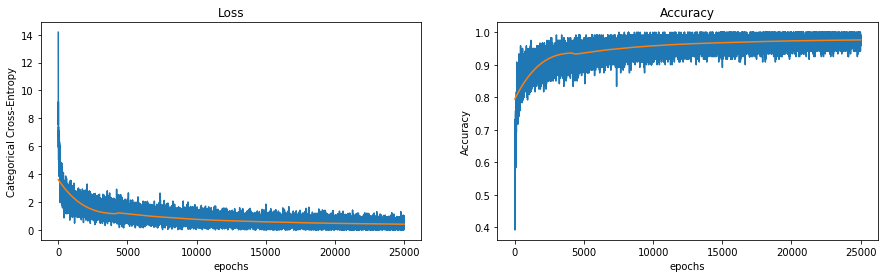

In [10]:
plt.figure(figsize = (15, 4))  # adjust figures size
plt.subplots_adjust(wspace=0.2)  # adjust distance

from scipy.signal import savgol_filter

# loss plot
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.plot(savgol_filter(loss_history, len(loss_history)//3, 3))
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Categorical Cross-Entropy')

# accuracy plot
plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.plot(savgol_filter(accuracy_history, len(loss_history)//3, 3))
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')

plt.show()

# 3. Test

Let's now test the model on the Test set. I will repeat the dataprep part on it:

In [11]:
# Dataprep Test data

test = pd.read_csv('fashion-mnist_test.csv')

test_label = pd.get_dummies(test.label)
test_label = test_label.values
test_label = test_label.astype(np.float32)

test.drop('label', axis = 1, inplace = True)
test = test.values
test = test.astype(np.float32)

test = test / 255.

test = test.reshape((len(test), 28, 28, 1))

prediction = CNN.predict(test)

prediction = np.argmax(prediction, axis=1)
test_label = np.argmax(test_label, axis=1)  # reverse one-hot encoding

In [12]:
from sklearn.metrics import confusion_matrix

CM = confusion_matrix(prediction, test_label)
print(CM)
print('\nTest Accuracy: ' + str(np.sum(np.diag(CM)) / np.sum(CM)))

[[855   2  13  13   4   1  92   0   4   0]
 [  0 980   2   2   0   2   4   0   1   0]
 [ 19   1 848   6  23   0  41   0   2   0]
 [ 18  13   9 926   9   0  23   0   1   0]
 [  2   1  74  35 936   0  74   1   3   0]
 [  0   0   0   0   0 963   1   9   0   6]
 [ 92   2  50  16  26   0 757   0   4   0]
 [  1   0   0   0   0  17   0 966   2  32]
 [ 13   1   4   1   2   3   8   0 983   5]
 [  0   0   0   1   0  14   0  24   0 957]]

Test Accuracy: 0.9171


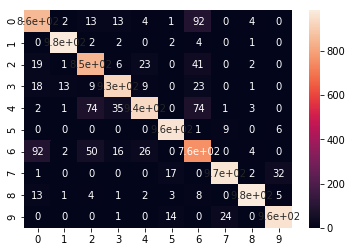

In [13]:
seaborn.heatmap(CM, annot=True)
plt.show()

My Convolutional Neural Network classified 91.7% of Test data correctly. The confusion matrix showed that category no. 6 (Shirt) has been misclassified the most. The next goal is to correct it; one possible solution would be to increase regularization, another to build an ensemble of models.

Thanks for coming thus far. In the next Notebooks I will implement more advanced Convolutional models, among other things.